In [1]:
!pip install fasttext
!pip install nltk
# !pip install memory_profiler
# !pip install -U mkl
# !pip install -U numpy
# !pip install --upgrade tensorflow
# !pip install --upgrade keras

You should consider upgrading via the '/usr/bin/python3.6 -m pip install --upgrade pip' command.
You should consider upgrading via the '/usr/bin/python3.6 -m pip install --upgrade pip' command.


# Экспериментальная часть

In [2]:
import numpy as np
import pandas as pd
import nltk
from sklearn.feature_extraction.text import CountVectorizer,TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold, KFold
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, fbeta_score
import string
from scipy.spatial.distance import jensenshannon
import scipy.io as sio
from scipy.special import rel_entr, kl_div
from scipy.stats import entropy, ks_2samp
from scipy.spatial.distance import jensenshannon
from scipy.special import rel_entr
# from skmultiflow.drift_detection import DDM, PageHinkley, ADWIN
# from skmultiflow.data import Conc>eptDriftStream
import datetime
from sklearn.datasets import load_svmlight_file
import matplotlib.pyplot as plt
import os
from tensorflow.keras.layers import Input, LSTM, Bidirectional, Dense, Embedding, Flatten, BatchNormalization, Dropout
from tensorflow.keras.models import Sequential
from tensorflow.keras.backend import clear_session
from tensorflow.keras.utils import to_categorical
# import tensorflow as tf
from sys import getsizeof
from sys import getrefcount
import gc
import fasttext.util
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing import sequence
from tensorflow import keras
import random
import matplotlib.pyplot as plt
from tensorflow.keras.layers.experimental.preprocessing import TextVectorization
import joblib
import tensorflow as tf
# import memory_profiler

In [3]:
# fasttext.util.download_model('en', if_exists='ignore')
ft = fasttext.load_model('cc.en.300.bin')
samples_number = 7

### Подготовка данных

In [4]:
# # porter_stemmer = nltk.stem.PorterStemmer()
# # tok = CountVectorizer().build_tokenizer()
# df_all = pd.read_csv('Electronics_5.csv')
# df_all.reviewTime = pd.to_datetime(df_all.reviewTime, format="%m %d, %Y")
# df_all = df_all.sort_values(by = 'reviewTime').reset_index(drop = True)
# df_all["bin_label"] = df_all.overall > 3
# df_all['label'] = df_all.overall.apply(lambda x: 2 if x == 3 else (1 if x < 3 else 3))
# df_all["words"] = list(map(lambda elem: (" ").join(map(lambda s: (porter_stemmer.stem(s)), elem)).lower().translate(str.maketrans('', '', string.punctuation)), map(lambda wrds: tok(wrds), df_all.reviewText.apply(lambda x: np.str_(x)))))

In [5]:
# df_by_years = {}
# for year in df_all.reviewTime.dt.year.unique().tolist():
#     df_by_years[year] = df_all[df_all.reviewTime.dt.year == year].reset_index(drop = True)
#     print(year, len(df_by_years[year]))
#     print(df_by_years[year].bin_label.value_counts(), '\n')

In [6]:
# skf = StratifiedKFold(n_splits=samples_number)
# for year in range(2007, 2015):
#     data_tmp = df_by_years[year].sample(35000)
#     data_list = []
#     index = 0
#     for train_index, test_index in skf.split(data_tmp.words, data_tmp.label):
#         data = data_tmp.iloc[test_index]
#         data[['words', 'label']].to_csv('data/{0}_{1}.csv'.format(year, index))
#         index += 1
#     print(year)
# del df_by_years
# del df_all
# del porter_stemmer
# del tok
# gc.collect()

### Вычисления

In [19]:
df_accuracy = pd.DataFrame(np.zeros([2015-2007, (2015-2007)*samples_number]), index=range(2007, 2015), columns=pd.MultiIndex.from_product([range(2007, 2015), range(samples_number)]))
df_tvd_lstm = df_accuracy.copy()
df_js_lstm = df_accuracy.copy()
df_ks_lstm = df_accuracy.copy()
df_kl_lstm = df_accuracy.copy()
df_tvd_tfidf = df_accuracy.copy()
df_js_tfidf = df_accuracy.copy()
df_ks_tfidf = df_accuracy.copy()
df_kl_tfidf = df_accuracy.copy()
df_tvd_count = df_accuracy.copy()
df_js_count = df_accuracy.copy()
df_ks_count = df_accuracy.copy()
df_kl_count = df_accuracy.copy()
df_perc_no_zero = df_accuracy.copy()
df_f1 = df_accuracy.copy()
df_accuracy

2007                               2008            ... 2013            \
        0    1    2    3    4    5    6    0    1    2  ...    4    5    6   
2007  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0  0.0  0.0   
2008  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0  0.0  0.0   
2009  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0  0.0  0.0   
2010  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0  0.0  0.0   
2011  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0  0.0  0.0   
2012  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0  0.0  0.0   
2013  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0  0.0  0.0   
2014  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0  0.0  0.0   

     2014                                
        0    1    2    3    4    5    6  
2007  0.0  0.0  0.0  0.0  0.0  0.0  0.0  
2008  0.0  0.0  0.0  0.0  0.0  0.0  0.0  
2009  0.0  0.0  0.0  0.0  0.0  0.0  0.0  
2010  0.0  0.0  0.0  0.0  0.0  0.0  0.0  
2011  0.0  0.0  0.0  0.0  0.0  0.0  0.0  
2012  0.0  0.0  0.0  0.0  0.0  0.0  0.0  
2013  0.0  0.0  0.0  0.0  0.0  0.0  0.0  
2014  0.0  0.0  0.0  0.0  0.0  0.0  0.0  

[8 rows x 56 columns]

In [20]:
def Generator(X_data, y_data, batch_size):

    samples_per_epoch = X_data.shape[0]
    number_of_batches = samples_per_epoch/batch_size
    counter=0

    while 1:

        X_batch = np.array(X_data[batch_size*counter:batch_size*(counter+1)])
        y_batch = np.array(y_data[batch_size*counter:batch_size*(counter+1)])
        
        counter += 1
        yield X_batch,y_batch
        
        if counter >= number_of_batches:
            counter = 0

In [21]:
def ReadData(year, index):
    data = pd.read_csv('data/{0}_{1}.csv'.format(year, index), index_col=[0])['words'].astype(str)
    labels = (pd.read_csv('data/{0}_{1}.csv'.format(year, index), index_col=[0])['label'])
    return data, labels

def FormTrainData(year_train, test_index, samples_number):
    train_data = pd.Series(dtype=pd.StringDtype())
    train_labels = pd.Series(dtype=int)
    for train_index in range(samples_number):
        if test_index != train_index:
            data, labels = ReadData(year_train, train_index)
            train_data = train_data.append(data)
            train_labels = train_labels.append(labels)
    return train_data, train_labels


def BuildEmbeddingMatrix(nb_words, word_index):
    embedding_matrix = np.zeros((nb_words, 300))
    for word, i in word_index.items():
        if i >= nb_words:
            continue
        try:
            embedding_vector = ft.get_word_vector(word)
        except KeyError:
            embedding_vector = None
        if (embedding_vector is not None) and len(embedding_vector) > 0:
            embedding_matrix[i] = embedding_vector
    return embedding_matrix


def BuildModel(embedding_matrix):
    inputs = keras.Input(shape=(None,), dtype="int64")#(shape=(train_data.shape[1],))        
    x = Embedding(nb_words, 300,input_length=train_data.shape[1], weights=[embedding_matrix],trainable=False)(inputs)
    outputs_dist = Bidirectional(LSTM(64))(x)
    distribution_model = keras.Model(inputs=inputs, outputs=outputs_dist, name="distribution")
#     y = BatchNormalization()(outputs_dist)
    y = Dense(32,activation='relu')(outputs_dist)
#     y = Dropout(0.5)(y)
    outputs = Dense(4,activation='softmax')(y)
    model = keras.Model(inputs=inputs, outputs=outputs, name="model")
    return model, distribution_model

def fbeta(ytrue , ypred, beta=1, epsilon=1e-7):
    beta_squared = beta**2
    ytrue = tf.cast(ytrue, tf.float32)
    ypred= tf.cast(ypred, tf.float32)
    
    max_prob = tf.reduce_max(ypred, axis=-1, keepdims=True)

    ypred = tf.cast(tf.equal(ypred, max_prob), tf.float32)
        
    tp = tf.reduce_sum(ytrue*ypred, axis=0)
    predicted_positive = tf.reduce_sum(ypred, axis=0) 
    actual_positive = tf.reduce_sum(ytrue, axis=0) 
    
    precision = tp/(predicted_positive+epsilon)
    recall = tp/(actual_positive+epsilon)

    fb = (1+beta_squared)*precision*recall / (beta_squared*precision + recall + epsilon)

    return tf.reduce_mean(fb)
    

In [ ]:
for year_train in range(2007, 2015):
    for test_index in range(0, samples_number):
        print('01_initialization')
        vecotrizer_tfidf = TfidfVectorizer(max_df = 0.9, min_df = 10, ngram_range=(1, 3))
        vecotrizer_count = CountVectorizer(max_df = 0.9, min_df = 10, ngram_range=(1, 3))
        vectorizer = TextVectorization(max_tokens=10000, output_sequence_length=300)
        
        print('\n02_Build_train_data')
        train_data, train_labels = FormTrainData(year_train, test_index, samples_number)
        
        print('\n03_Data_Vectorization')
        
        train_data_tfidf = vecotrizer_tfidf.fit_transform(train_data)
        joblib.dump(vecotrizer_tfidf, 'vecotrizer_tfidf.pkl')
        joblib.dump(train_data_tfidf, 'train_data_tfidf.pkl')
        del vecotrizer_tfidf
        del train_data_tfidf
        
        train_data_count = vecotrizer_count.fit_transform(train_data)
        joblib.dump(vecotrizer_count, 'vecotrizer_count.pkl')
        joblib.dump(train_data_count, 'train_data_count.pkl')
        del vecotrizer_count
        del train_data_count
        
        vectorizer.adapt(train_data.values)
        voc = vectorizer.get_vocabulary()
        word_index = dict(zip(voc, range(len(voc))))
        nb_words = len(voc)+2
        train_data = vectorizer(np.array([[s] for s in train_data])).numpy()
#         joblib.dump(vectorizer, 'vectorizer.pkl')
#         del vectorizer
        
        gc.collect()
        
        print('\n04_Build_embedding_matrix')
        embedding_matrix = BuildEmbeddingMatrix(nb_words, word_index)
        
        print('\n05_Build_model')
        model, distribution_model = BuildModel(embedding_matrix)       
        model.compile(
            loss='categorical_crossentropy',
            optimizer='adam',
            metrics=[fbeta],
        )
#         model.summary()
        
        print('\n06_Fit_model')
        
        test_data, test_labels = ReadData(year_train, test_index)
        batch_size = 16
        gen = Generator(train_data, to_categorical(train_labels), batch_size)
        history = model.fit(
                gen,
                epochs=10,
                steps_per_epoch = train_data.shape[0]//batch_size,
                validation_data = Generator(test_data, to_categorical(test_labels),batch_size*2),
                validation_steps = (test_data.shape[0]/batch_size*2)
        )
        
        print('\n07_Test_years')
        
        train_data_tfidf = joblib.load('train_data_tfidf.pkl')
        train_data_count = joblib.load('train_data_count.pkl')
        lstm_dist_train = np.mean(distribution_model.predict(train_data), axis = 0)
        tfidf_dist_train = np.array(np.mean(train_data_tfidf, axis = 0))[0,:]
        count_dist_train = np.array(np.mean(train_data_count, axis = 0))[0,:]
        del train_data_tfidf
        del train_data_count
        
        for year_test in range(year_train, 2015):
            
            test_data, test_labels = ReadData(year_test, test_index)
            
            vecotrizer_tfidf = joblib.load('vecotrizer_tfidf.pkl')
            tfidf_dist_test = np.array(np.mean(vecotrizer_tfidf.transform(test_data), axis = 0))[0,:]
            del vecotrizer_tfidf
            
            vecotrizer_count = joblib.load('vecotrizer_count.pkl')
            count_dist_test = np.array(np.mean(vecotrizer_count.transform(test_data), axis = 0))[0,:]
            del vecotrizer_count
#             vectorizer = joblib.load('vecotrizer.pkl')
            test_data = vectorizer(np.array([[s] for s in test_data])).numpy()
#             del vectorizer
            loss, accuracy = model.evaluate(test_data, to_categorical(test_labels), verbose=False)
            df_f1.loc[year_train][year_test][test_index] = accuracy
            
            lstm_dist_test = np.mean(distribution_model.predict(test_data), axis = 0)           
            
            df_tvd_lstm.loc[year_train][year_test][test_index] = sum(abs(lstm_dist_train - lstm_dist_test))/2
            df_js_lstm.loc[year_train][year_test][test_index] = jensenshannon(lstm_dist_train, lstm_dist_test)
            df_ks_lstm.loc[year_train][year_test][test_index] = ks_2samp(lstm_dist_train, lstm_dist_test).statistic
            df_kl_lstm.loc[year_train][year_test][test_index] = sum(rel_entr(lstm_dist_train, lstm_dist_test))
            
            df_tvd_tfidf.loc[year_train][year_test][test_index] = sum(abs(tfidf_dist_train - tfidf_dist_test))/2
            df_js_tfidf.loc[year_train][year_test][test_index] = jensenshannon(tfidf_dist_train, tfidf_dist_test)
            df_ks_tfidf.loc[year_train][year_test][test_index] = ks_2samp(tfidf_dist_train, tfidf_dist_test).statistic
            df_kl_tfidf.loc[year_train][year_test][test_index] = sum(rel_entr(tfidf_dist_train, tfidf_dist_test))
            
            df_tvd_count.loc[year_train][year_test][test_index] = sum(abs(count_dist_train - count_dist_test))/2
            df_js_count.loc[year_train][year_test][test_index] = jensenshannon(count_dist_train, count_dist_test)
            df_ks_count.loc[year_train][year_test][test_index] = ks_2samp(count_dist_train, count_dist_test).statistic
            df_kl_count.loc[year_train][year_test][test_index] = sum(rel_entr(count_dist_train, count_dist_test))
            
            df_perc_no_zero.loc[year_train][year_test][test_index] = np.count_nonzero(count_dist_test)/np.count_nonzero(count_dist_train)            
            
            print("Train in {0}, test in {1}, test sample {2}\naf1_score = {3}".format(year_train, year_test, test_index, df_f1.loc[year_train][year_test][test_index]))
            del test_data
            del test_labels
            del loss
            del accuracy
            gc.collect()
        
        print('step 8')
        clear_session()
        del model
        del train_data
        del train_labels
        del gen
        gc.collect()

01_initialization

02_Build_train_data

03_Data_Vectorization

04_Build_embedding_matrix

05_Build_model

06_Fit_model
  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 1875 steps, validate for 625.0 steps
Epoch 1/10
1873/1875 [============================>.] - ETA: 0s - loss: 0.6501 - fbeta: 0.2194

### Полученные значения

In [61]:
def df_mean_values(df_values):
    df_mean = pd.DataFrame(np.zeros([2015-2007, 2015-2007]), index=range(2007, 2015), columns=range(2007, 2015))

    for year_train in range(2007, 2015):
        for year_test in range(year_train, 2015):
            df_mean.loc[year_train][year_test] = df_values.loc[year_train][year_test].mean()
    
    max_val = df_mean.values.max()
    df_mean[df_mean.eq(0)] = np.nan
    df_mean = max_val - df_mean
    ur_style = (df_mean
                .style
                .background_gradient(cmap='Greens', axis=0)
                .highlight_null('white')
                .format("{:.3}", na_rep=""))
    return(ur_style)

In [92]:
df_f1_mean = pd.DataFrame(np.zeros([2015-2007, 2015-2007]), index=range(2007, 2015), columns=range(2007, 2015))

for year_train in range(2007, 2015):
    for year_test in range(year_train, 2015):
        df_f1_mean.loc[year_train][year_test] = df_f1.loc[year_train][year_test].mean()

df_f1_mean[df_f1_mean.eq(0)] = np.nan
ur_style = (df_f1_mean
            .style
            .background_gradient(cmap='Greens', axis=0)
            .highlight_null('white')
            .format("{:.3}", na_rep=""))
ur_style


,2007,2008,2009,2010,2011,2012,2013,2014
2007,0.352,0.348,0.343,0.348,0.347,0.349,0.346,0.347
2008,,0.345,0.341,0.34,0.341,0.345,0.337,0.334
2009,,,0.338,0.338,0.336,0.34,0.338,0.336
2010,,,,0.35,0.349,0.354,0.344,0.344
2011,,,,,0.342,0.343,0.342,0.345
2012,,,,,,0.37,0.369,0.367
2013,,,,,,,0.344,0.343
2014,,,,,,,,0.347


In [93]:
df_mean_values(df_tvd_lstm)

,2007,2008,2009,2010,2011,2012,2013,2014
2007,0.772,0.719,0.651,0.665,0.71,0.629,0.341,0.284
2008,,0.769,0.739,0.739,0.673,0.522,0.203,0.142
2009,,,0.782,0.747,0.664,0.463,0.0777,0.0
2010,,,,0.766,0.703,0.472,0.0877,0.0147
2011,,,,,0.789,0.597,0.198,0.12
2012,,,,,,0.777,0.344,0.248
2013,,,,,,,0.768,0.711
2014,,,,,,,,0.768


In [64]:
df_mean_values(df_ks_lstm)

,2007,2008,2009,2010,2011,2012,2013,2014
2007,0.0558,0.0513,0.048,0.0491,0.0558,0.0435,0.0246,0.0212
2008,,0.0536,0.0569,0.0513,0.0469,0.0312,0.0179,0.0134
2009,,,0.0569,0.0525,0.0402,0.0246,0.00781,0.0
2010,,,,0.0569,0.0502,0.0368,0.0179,0.0201
2011,,,,,0.0558,0.0379,0.0179,0.0145
2012,,,,,,0.0547,0.019,0.019
2013,,,,,,,0.0592,0.0525
2014,,,,,,,,0.058


In [65]:
df_mean_values(df_tvd_tfidf)

,2007,2008,2009,2010,2011,2012,2013,2014
2007,1.21,1.12,0.989,0.84,0.676,0.477,0.164,0.0603
2008,,1.17,1.08,0.936,0.753,0.501,0.122,0.00533
2009,,,1.14,1.04,0.838,0.554,0.129,0.0
2010,,,,1.16,1.04,0.759,0.318,0.185
2011,,,,,1.22,1.04,0.609,0.474
2012,,,,,,1.33,1.05,0.928
2013,,,,,,,1.52,1.48
2014,,,,,,,,1.56


In [66]:
df_mean_values(df_js_tfidf)

,2007,2008,2009,2010,2011,2012,2013,2014
2007,0.101,0.1,0.0936,0.0809,0.0627,0.0396,0.00987,0.0
2008,,0.101,0.0984,0.0869,0.0693,0.0453,0.014,0.00399
2009,,,0.101,0.0928,0.0759,0.0519,0.0191,0.00858
2010,,,,0.101,0.09,0.067,0.0336,0.0227
2011,,,,,0.101,0.0842,0.0505,0.0398
2012,,,,,,0.101,0.0721,0.062
2013,,,,,,,0.1,0.0927
2014,,,,,,,,0.0998


In [67]:
df_mean_values(df_ks_tfidf)

,2007,2008,2009,2010,2011,2012,2013,2014
2007,0.17,0.176,0.172,0.155,0.128,0.0825,0.0184,0.00269
2008,,0.169,0.169,0.153,0.127,0.0805,0.0152,0.0
2009,,,0.171,0.157,0.131,0.0854,0.0186,0.00273
2010,,,,0.17,0.149,0.104,0.0356,0.0196
2011,,,,,0.172,0.132,0.0614,0.0456
2012,,,,,,0.173,0.105,0.0891
2013,,,,,,,0.177,0.162
2014,,,,,,,,0.176


In [68]:
df_mean_values(df_tvd_count)

,2007,2008,2009,2010,2011,2012,2013,2014
2007,55.1,51.0,45.2,45.1,45.0,37.7,18.8,13.7
2008,,54.0,50.5,49.1,44.9,33.1,11.5,6.07
2009,,,52.8,50.0,42.8,29.0,5.65,0.0
2010,,,,53.4,48.9,35.4,12.0,6.26
2011,,,,,55.4,46.1,23.3,17.7
2012,,,,,,58.3,40.6,35.2
2013,,,,,,,63.0,61.1
2014,,,,,,,,64.2


In [69]:
df_mean_values(df_js_count)

,2007,2008,2009,2010,2011,2012,2013,2014
2007,0.0882,0.0862,0.0795,0.0674,0.0513,0.032,0.00904,0.0
2008,,0.0889,0.0858,0.0748,0.0594,0.0393,0.015,0.00577
2009,,,0.089,0.0807,0.0658,0.0457,0.0201,0.0105
2010,,,,0.0887,0.0787,0.0598,0.0336,0.0236
2011,,,,,0.0884,0.0746,0.0483,0.0388
2012,,,,,,0.089,0.0661,0.0574
2013,,,,,,,0.0874,0.081
2014,,,,,,,,0.0867


In [70]:
df_mean_values(df_ks_count)

,2007,2008,2009,2010,2011,2012,2013,2014
2007,0.253,0.265,0.269,0.246,0.211,0.15,0.0456,0.0171
2008,,0.253,0.261,0.239,0.204,0.141,0.035,0.00711
2009,,,0.255,0.234,0.196,0.133,0.0273,0.0
2010,,,,0.253,0.221,0.156,0.0466,0.0206
2011,,,,,0.254,0.192,0.0764,0.0492
2012,,,,,,0.254,0.134,0.105
2013,,,,,,,0.253,0.224
2014,,,,,,,,0.252


In [71]:
df_perc_no_zero_mean = pd.DataFrame(np.zeros([2015-2007, 2015-2007]), index=range(2007, 2015), columns=range(2007, 2015))

for year_train in range(2007, 2015):
    for year_test in range(year_train, 2015):
        df_perc_no_zero_mean.loc[year_train][year_test] = df_perc_no_zero.loc[year_train][year_test].mean()

df_perc_no_zero_mean[df_perc_no_zero_mean.eq(0)] = np.nan
ur_style = (df_perc_no_zero_mean
            .style
            .background_gradient(cmap='Greens', axis=0)
            .highlight_null('white')
            .format("{:.3%}", na_rep=""))
ur_style

,2007,2008,2009,2010,2011,2012,2013,2014
2007,90.901%,91.333%,91.166%,89.785%,87.419%,83.456%,76.401%,74.025%
2008,,90.926%,91.164%,89.820%,87.523%,83.410%,76.128%,73.786%
2009,,,91.027%,89.855%,87.661%,83.604%,76.051%,73.649%
2010,,,,91.041%,89.262%,85.536%,78.226%,75.870%
2011,,,,,91.013%,87.985%,80.999%,78.770%
2012,,,,,,90.949%,84.967%,83.020%
2013,,,,,,,90.985%,89.596%
2014,,,,,,,,91.003%


### Корреляция

In [72]:
def transform_df_to_arr(df):
    arr = df.to_numpy().reshape(7*8*8,)
    arr = arr[arr != 0]
    return(arr)

def search_correlation(df_1, df_2):
    arr_1 = transform_df_to_arr(df_1)
    arr_2 = transform_df_to_arr(df_2)
    plt.scatter(arr_1, arr_2)
    return(np.corrcoef(arr_1, arr_2)[0, 1])

0.0014693853739169644

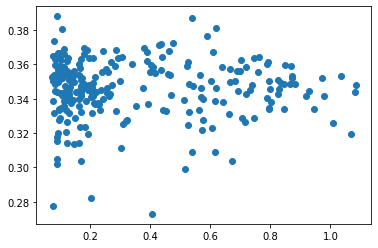

In [73]:
search_correlation(df_tvd_lstm, df_f1)

-0.006237518651518579

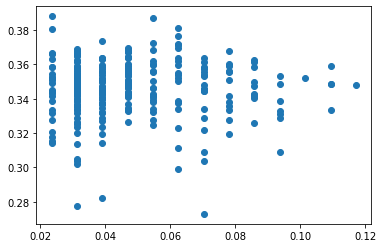

In [74]:
search_correlation(df_ks_lstm, df_f1)

-0.16127189532687047

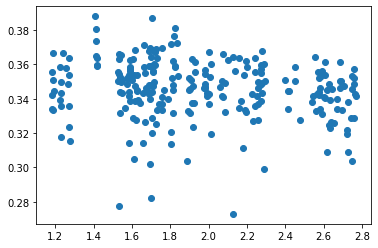

In [75]:
search_correlation(df_tvd_tfidf, df_f1)

-0.11421774887842283

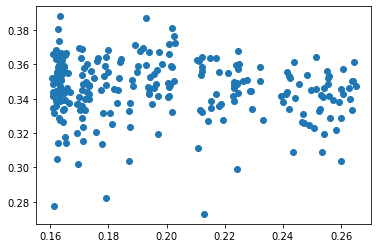

In [76]:
search_correlation(df_js_tfidf, df_f1)

-0.09696547022767649

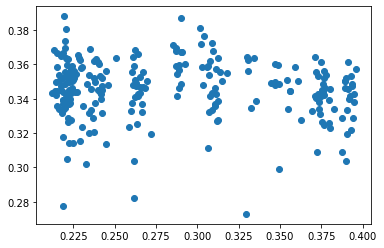

In [77]:
search_correlation(df_ks_tfidf, df_f1)

-0.13235968063309717

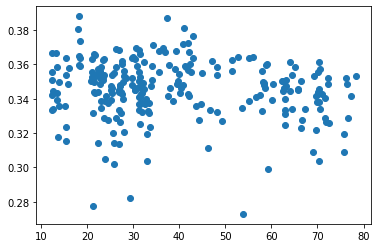

In [78]:
search_correlation(df_tvd_count, df_f1)

-0.11833153874987805

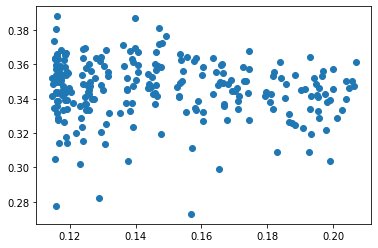

In [79]:
search_correlation(df_js_count, df_f1)

-0.07392808737744473

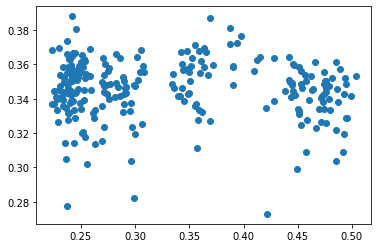

In [80]:
search_correlation(df_ks_count, df_f1)

0.09828147153751608

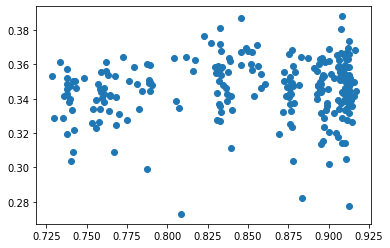

In [81]:
search_correlation(df_perc_no_zero, df_f1)

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, None)]            0         
_________________________________________________________________
embedding_1 (Embedding)      (None, None, 300)         3000300   
_________________________________________________________________
bidirectional_1 (Bidirection (None, 128)               186880    
_________________________________________________________________
dense_2 (Dense)              (None, 32)                4128      
_________________________________________________________________
dense_3 (Dense)              (None, 4)                 132       
Total params: 3,191,440
Trainable params: 191,140
Non-trainable params: 3,000,300
_________________________________________________________________
None


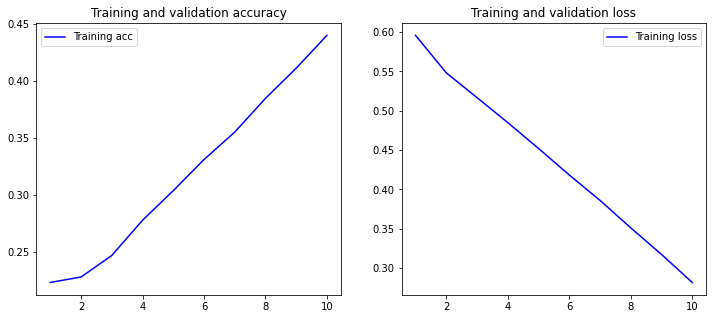

In [18]:
def plot_history(history):
    acc = history.history['fbeta']
#     val_acc = history.history['val_accuracy']
    loss = history.history['loss']
#     val_loss = history.history['val_loss']
    x = range(1, len(acc) + 1)

    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(x, acc, 'b', label='Training acc')
#     plt.plot(x, val_acc, 'r', label='Validation acc')
    plt.title('Training and validation accuracy')
    plt.legend()
    plt.subplot(1, 2, 2)
    plt.plot(x, loss, 'b', label='Training loss')
#     plt.plot(x, val_loss, 'r', label='Validation loss')
    plt.title('Training and validation loss')
    plt.legend()

print(model.summary())
plot_history(history)